# k arm bandit 

this notebook is an attmpt to create a k armed bandit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#set variables
k = 10
reward_range_min = 1
reward_range_max = 10
std_min = 1
std_max = 1
samples_per_distrib = 1000



In [3]:
#create arms and rewards
reward_stack = []
max_mean = 0
best_arm = 0

for i in range(0,k):
    #select mean for this arm
    current_mean = np.random.choice(a = list(range(reward_range_min,reward_range_max+1)), size = 1)
    
    if max_mean == current_mean:
        current_mean += 1 
    
    if max_mean < current_mean:
        max_mean = current_mean
        best_arm = i
        
    #to debug
    print(i , current_mean)
    
    #select std for this arm
    current_std = np.random.choice(a = list(range(std_min,std_max+1)), size = 1)
    #to debug
    #print(current_std)
    
    #draw samples for this arm
    current_arm = np.random.normal(loc = current_mean, scale = current_std, size = samples_per_distrib)
    #to debug
    #print(current_arm)
    
    #append to reward stack list 
    reward_stack.append(current_arm)
    #to debug
    #print(reward_stack)
    
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  


0 [10]
1 [3]
2 [9]
3 [5]
4 [11]
5 [3]
6 [9]
7 [9]
8 [8]
9 [1]
the maximum mean is : [11]
the best arm is : 4


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f3f61f939a0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7f3f61f93e80>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f3f61f3e4c0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f3f61f3e970>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f3f61f3ee20>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7f3f61f58310>}

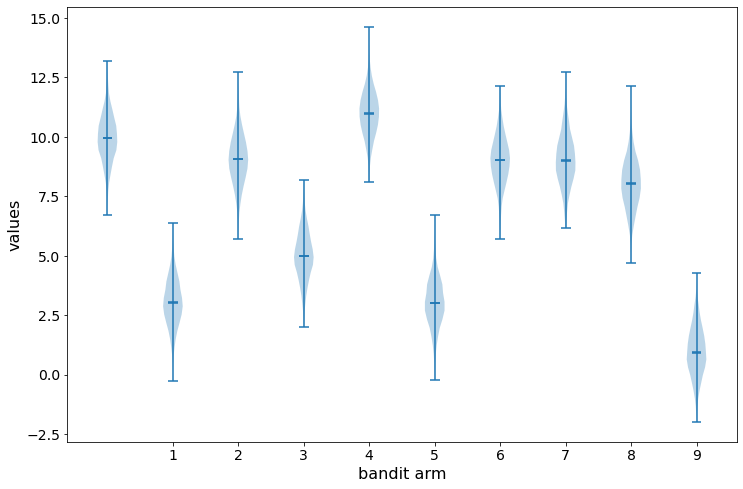

In [4]:
#alter plot size so it looks decent
#makes viz bigger
import matplotlib.pyplot as plt
BIG = 16
MED = 14
SMALL = 10
plt.rcParams.update({'font.size': BIG})
plt.rcParams.update({'axes.labelsize': BIG})
plt.rcParams.update({'xtick.labelsize': MED})
plt.rcParams.update({'ytick.labelsize': MED})
plt.rcParams.update({'figure.figsize':[12, 8]}) #this is important as it makes the visualizations much easier to read and clip/export!(w,h)

#plot reward stack and arms
plt.xticks(ticks=list(range(1,k+1)), labels=list(range(1,k+1)))

plt.xlabel("bandit arm")

plt.ylabel("values")

plt.violinplot(reward_stack, list(range(0,k)), points=20, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True)



In [5]:
#random selection without any value assesments

#set base vars
n = 1000

#set objects needed
arms_selected = []
total_reward = 0

for i in range(0,n):
    
    #randomly pick an arm
    current_arm = np.random.choice(range(0,k))
    
    #append choice to list tracking what was done
    arms_selected.append(current_arm)
    
    #randomly pick a reward from the distrib
    current_reward = np.random.choice(reward_stack[current_arm])
    
    #add current reward to total rewards
    total_reward = total_reward + current_reward
    

print("total reward from random selection:",total_reward)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print(pd.Series(arms_selected).value_counts(normalize = True).sort_index())

total reward from random selection: 6738.241173278457
the maximum mean is : [11]
the best arm is : 4
0    0.093
1    0.100
2    0.090
3    0.099
4    0.104
5    0.102
6    0.111
7    0.091
8    0.105
9    0.105
dtype: float64


In [6]:
#epsilon greedy solution

#example for setting base vars
n = 1000
reward_step = .9 #used with nonstationary tracking, set to one for stationary problems
epsilon = 0.1

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

##############################################################################################
#some basic helper functions
##############################################################################################

#use epsilon to make explouit or explore decision:
def exploit_or_explore(epsilon):
    
    exp = np.random.binomial(1, epsilon, 1)
    
    return exp

#value assesment
def arm_max(expected_rewards):
    
    maxx = np.argsort(expected_rewards)[-1]
    
    #debug
    #print(expected_rewards)
    #print(maxx)
    
    return maxx
    
#pull the arm selected
def pull_arm(current_arm):
    
    current_reward = np.random.choice(reward_stack[current_arm])
    
    return current_reward   

##############################################################################################
#some not so basic helper functions
##############################################################################################

#update reward expectations
def update_reward_expectation(expected_rewards, last_reward_list, reward_step, current_arm):
    
    prior_tweaked = (reward_step * (last_reward_list[current_arm] - expected_rewards[current_arm]))
    
    #debug
    #print(prior_tweaked)
    
    expected_rewards[current_arm] = expected_rewards[current_arm] + prior_tweaked
    
    #print(expected_rewards)
    
    return expected_rewards

#when epsilon is used for exploration
#select arm that has been selected the least number of times or random arm (not selecting the max arm)
def arm_explore(expected_rewards, count_arms_selected):
         
    #get the number of times each arm has been selected
    arm_breakdown = np.array(count_arms_selected)
    
    #check if first two are equal
    sorted_arm_indices = arm_breakdown.argsort()
    
    #debug
    #print(arm_breakdown)
    #print(sorted_arm_indices)
    #print("0:",arm_breakdown[sorted_arm_indices[0]])
    #print("1:",arm_breakdown[sorted_arm_indices[1]])
    
    #if first do not have equal counts then return lowest count
    if arm_breakdown[sorted_arm_indices[0]] != arm_breakdown[sorted_arm_indices[1]]:
        return sorted_arm_indices[0]
            
    #take random sample
    max_arm = arm_max(expected_rewards)
    
    rando_list = [i for i in range(0,k)]
    
    rando_list.remove(max_arm)
    
    selected_element = np.random.choice(rando_list)
    
    return selected_element


##############################################################################################
#main calls
##############################################################################################
#play one turn
def play_one(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step):
    
    if epsilon > 0:
    
        #get explore/exploit signal
        exp = exploit_or_explore(epsilon)
        
    else:
        exp = 0
    
    #explore
    if exp:
        current_arm = arm_explore(expected_rewards, count_arms_selected)
    
    #exploit
    else:
        current_arm = arm_max(expected_rewards)
        
        #debug
        #print(current_arm)
        
    #pull the arm
    current_reward = pull_arm(current_arm)
    
    #append reward to reward_list
    last_reward_list[current_arm] = current_reward
    
    #append arms selected to tracking
    count_arms_selected[current_arm] += 1  
    
    #print(current_arm)
    
    #update reward expectation
    expected_rewards = update_reward_expectation(expected_rewards, last_reward_list, reward_step, current_arm)
    
    #update total reward
    total_reward = total_reward + current_reward
    
    return expected_rewards, last_reward_list, count_arms_selected, total_reward

##############################################################################################
#play thru
##############################################################################################
def play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first):

    start = 0
    
    if explore_first:
        
        start = k
    
        #for first k rounds pull each arm available once to get started    
        for current_arm in range(0,k):
            #debug
            #print(i)
            current_reward = pull_arm(current_arm)

            #append arms selected to tracking
            count_arms_selected[current_arm] += 1  

            expected_rewards[current_arm] = current_reward

            #update total reward
            total_reward = total_reward + current_reward

            #debug
            #print(total_reward)
     
    #play thru remaining rounds
    for i in range(start,n):
        #debug
        #print(i)
    
        #start the process using epsilon greedy
        expected_rewards, last_reward_list, count_arms_selected, total_reward = play_one(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step)  
        
    return expected_rewards, last_reward_list, count_arms_selected, total_reward

In [7]:
#create run tracking
dummy_list = []
columns = ["explore first", "epsilon", "reward step", "total rewards"]

In [8]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = 1 #used with nonstationary tracking, set to one for stationary problems

#set to 0 so its totally greedy with no exploration
epsilon = 0

#set explore first to 1 to have algo pull each arm once
explore_first = 0

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  7830.042344134017 
epsilon =  0 
reward step =  1
the maximum mean is : [11]
the best arm is : 4
total times each arm selected: [  0   0   0   0   0   0   0   0 970  30]
final expected rewards: [ 0  0  0  0  0  0  0  0  8 -1]
final last rewards: [ 0  0  0  0  0  0  0  0  8 -1]


In [9]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = 1 #used with nonstationary tracking, set to one for stationary problems

#set to 0.1 so we eplore 10% of the time
epsilon = 0.1

#set explore first to 1 to have algo pull each arm once
explore_first = 0

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  10014.454955905498 
epsilon =  0.1 
reward step =  1
the maximum mean is : [11]
the best arm is : 4
total times each arm selected: [ 62  16  30  20 701  16  44  77  18  16]
final expected rewards: [9 3 8 4 9 3 7 8 7 2]
final last rewards: [9 3 8 4 9 3 7 8 7 2]


In [10]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = 1 #used with nonstationary tracking, set to one for stationary problems

#set to 0.01 so we eplore 1% of the time
epsilon = 0.01

#set explore first to 1 to have algo pull each arm once
explore_first = 0

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  8618.151097059916 
epsilon =  0.01 
reward step =  1
the maximum mean is : [11]
the best arm is : 4
total times each arm selected: [  0   0   0   2   0   1 630   0 361   6]
final expected rewards: [0 0 0 4 0 2 6 0 8 0]
final last rewards: [0 0 0 4 0 2 6 0 8 0]


In [11]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = .9 #used with nonstationary tracking, set to one for stationary problems

#set to 0.01 so we eplore 1% of the time
epsilon = 0.01

#set explore first to 1 to have algo pull each arm once
explore_first = 0

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  8972.927667362252 
epsilon =  0.01 
reward step =  0.9
the maximum mean is : [11]
the best arm is : 4
total times each arm selected: [172   1  19   2 245   1   5 445  35  75]
final expected rewards: [8 3 6 5 9 3 6 6 5 0]
final last rewards: [9 4 6 6 9 4 6 6 5 0]


In [12]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = 1 #used with nonstationary tracking, set to one for stationary problems

#set to 0 so its totally greedy with no exploration
epsilon = 0

#set explore first to 1 to have algo pull each arm once
explore_first = 1

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  10880.460806622701 
epsilon =  0 
reward step =  1
the maximum mean is : [11]
the best arm is : 4
total times each arm selected: [  2   1   1   1 977   1  14   1   1   1]
final expected rewards: [ 8  2  8  6 10  4  7  6  7  2]
final last rewards: [ 8  0  0  0 10  0  7  0  0  0]


In [13]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = 1 #used with nonstationary tracking, set to one for stationary problems

#set to 0.1 so we eplore 10% of the time
epsilon = 0.1

#set explore first to 1 to have algo pull each arm once
explore_first = 1

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  10193.977981064336 
epsilon =  0.1 
reward step =  1
the maximum mean is : [11]
the best arm is : 4
total times each arm selected: [ 31  12  33  12 735  15  68  58  24  12]
final expected rewards: [ 7  2  8  6  8  2  8 10  7  1]
final last rewards: [ 7  2  8  6  8  2  8 10  7  1]


In [14]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = 1 #used with nonstationary tracking, set to one for stationary problems

#set to 0.01 so we eplore 1% of the time
epsilon = 0.01

#set explore first to 1 to have algo pull each arm once
explore_first = 1

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  10855.092547897522 
epsilon =  0.01 
reward step =  1
the maximum mean is : [11]
the best arm is : 4
total times each arm selected: [  8   1   2   1 961   2  12   2   9   2]
final expected rewards: [ 8  4  7  4 10  3  6  6  7  0]
final last rewards: [ 8  0  7  0 10  3  6  6  7  0]


In [15]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = .9 #used with nonstationary tracking, set to one for stationary problems

#set to 0.01 so we eplore 1% of the time
epsilon = 0.01

#set explore first to 1 to have algo pull each arm once
explore_first = 1

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  10882.69557757302 
epsilon =  0.01 
reward step =  0.9
the maximum mean is : [11]
the best arm is : 4
total times each arm selected: [  2   1   3   1 969   2   2  17   1   2]
final expected rewards: [ 8  1  8  6 10  2  7  7  7  0]
final last rewards: [ 9  0  8  0 11  3  7  7  0  1]


In [16]:
import pandas as pd

df = pd.DataFrame(data = dummy_list, columns = columns)

df

,explore first,epsilon,reward step,total rewards
0,0,0.00,1.0,7830.042344
1,0,0.10,1.0,10014.454956
2,0,0.01,1.0,8618.151097
3,0,0.01,0.9,8972.927667
4,1,0.00,1.0,10880.460807
5,1,0.10,1.0,10193.977981
6,1,0.01,1.0,10855.092548
7,1,0.01,0.9,10882.695578


In [17]:
#bayesian agent with thompson sampling
#other congugate priors can be determined from the table of such in wikipedia here:https://en.wikipedia.org/wiki/Conjugate_prior
num_levers = len(reward_stack)
taus = [0.0001 for i in range(num_levers)]
mews = [1 for i in range(num_levers)]
actions = [0 for i in range(num_levers)]
rewards = [0 for i in range(num_levers)]
total_reward = 0

n = 1000

#pull the arm selected
def pull_arm(current_arm):
    
    current_reward = np.random.choice(reward_stack[current_arm])
    
    return current_reward   

def value_samples(taus, mews, num_levers):
    return [(np.random.randn() / np.sqrt(taus[i])) + mews[i] for i in range(num_levers)]

def choose_action(samples):
    return np.argmax(samples)

def update(taus, mews, rewards, action, actions):
    taus[action] += (1 * actions[action]) #we know preceision is one here b/c variance is 1
    mews[action] += ((mews[action] * taus[action]) + np.mean(rewards[action]))/(taus[action] + actions[action])
    return taus, mews
    
for i in range(n):
    samples = value_samples(taus, mews, num_levers)    
    action = choose_action(samples)
    actions[action] += 1
    reward = pull_arm(action)  
    rewards[action] +=  reward
    taus, mews = update(taus, mews, rewards, action, actions)
    total_reward += reward
    
dummy_list.append([-1, -1, -1, total_reward]) #-1 for all otehr variables to indicate bayesian

df = pd.DataFrame(data = dummy_list, columns = columns)

df.sort_values(by = ['total rewards'], ascending = False)

,explore first,epsilon,reward step,total rewards
8,-1,-1.00,-1.0,10949.160049
7,1,0.01,0.9,10882.695578
4,1,0.00,1.0,10880.460807
6,1,0.01,1.0,10855.092548
5,1,0.10,1.0,10193.977981
1,0,0.10,1.0,10014.454956
3,0,0.01,0.9,8972.927667
2,0,0.01,1.0,8618.151097
0,0,0.00,1.0,7830.042344
